In [1]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from udonpred_benchmarking.constants import DATA_DIR, PLOT_DIR
from udonpred_benchmarking.plots import QUARTILE_LABELS, set_theme

/tmp/ipykernel_323147/522275489.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_yticklabels(plot.get_yticklabels(), fontsize=2.5)
/tmp/ipykernel_323147/522275489.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_yticklabels(plot.get_yticklabels(), fontsize=2.5)
/tmp/ipykernel_323147/522275489.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_yticklabels(plot.get_yticklabels(), fontsize=2.5)
/tmp/ipykernel_323147/522275489.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_yticklabels(plot.get_yticklabels(), fontsize=2.5)


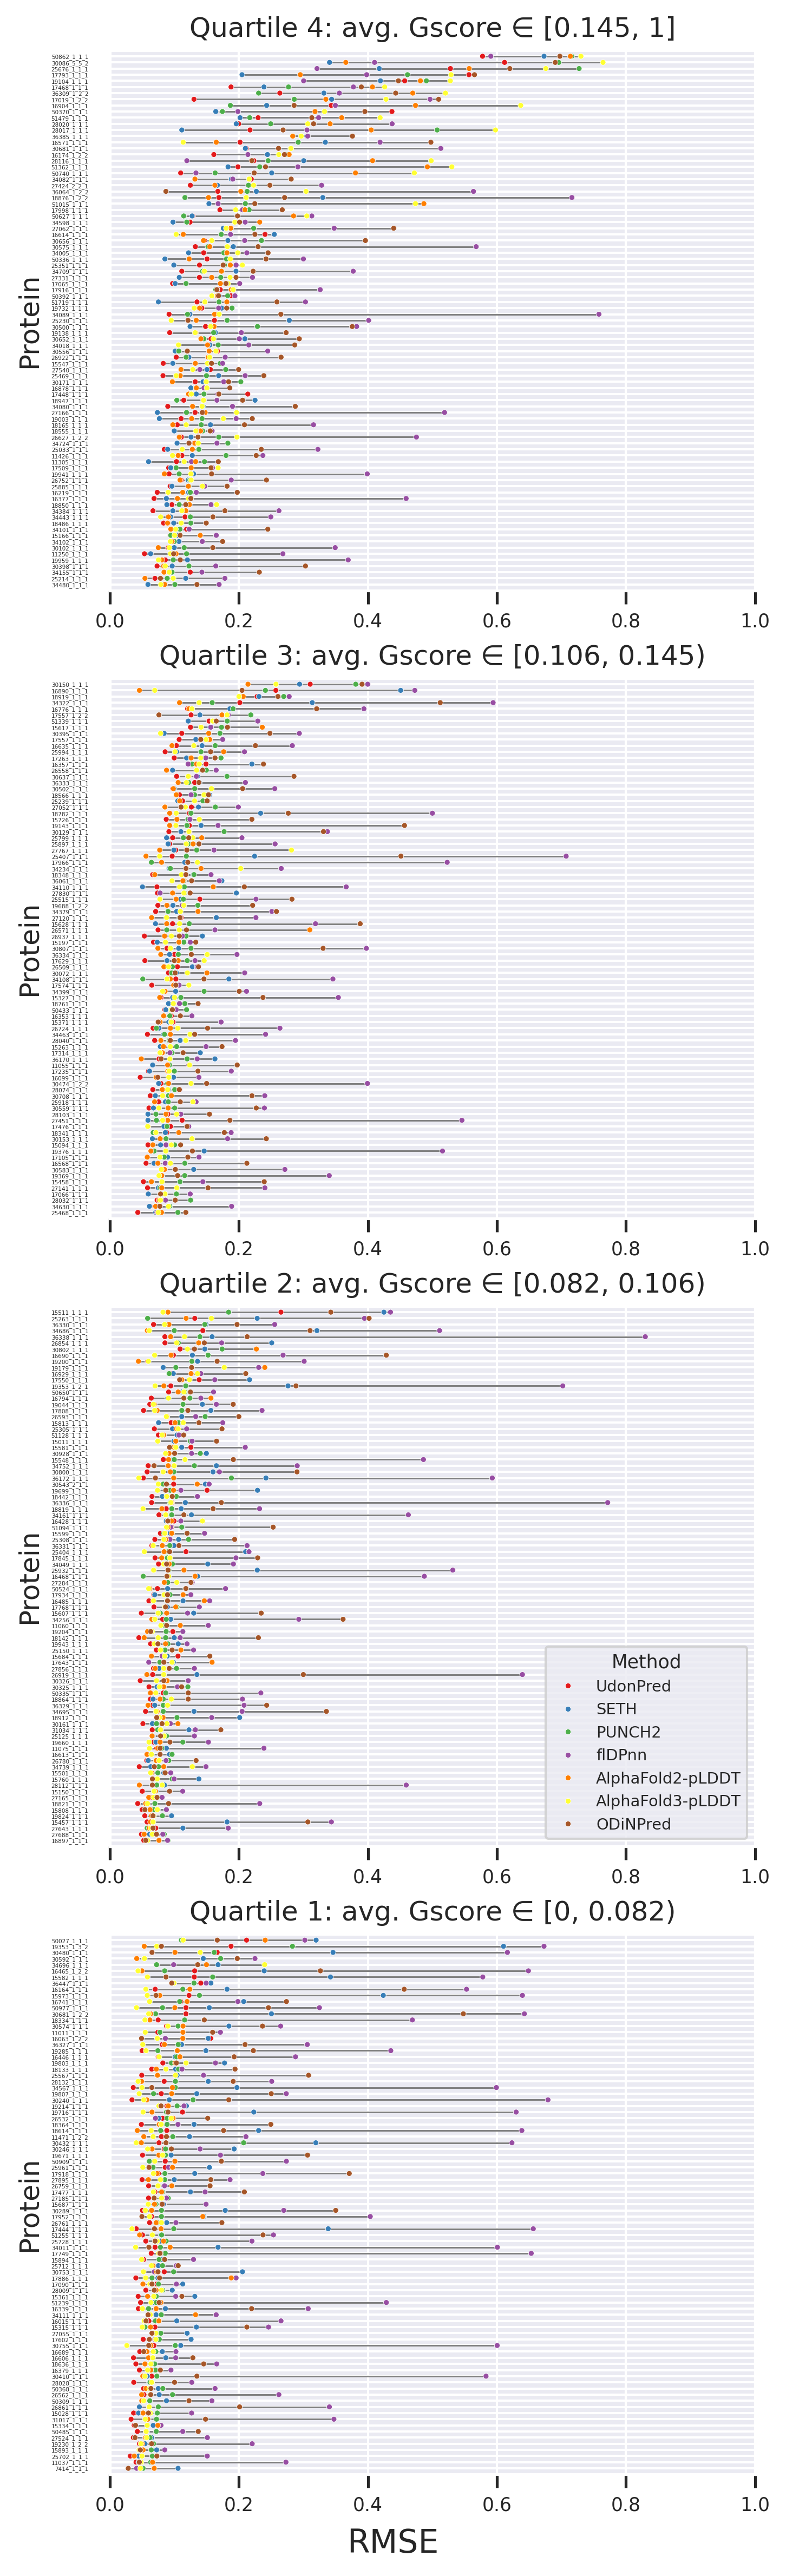

In [5]:
protein_df = pl.read_csv(DATA_DIR / "per_protein_performance.csv")
protein_stats = pl.read_csv(DATA_DIR / "per_protein_stats.csv")

set_theme()
sns.set_style("darkgrid")

METRIC = "rmse"


fig, axes = plt.subplots(nrows=4, sharex=True, **dict(figsize=[12 / 2.54, 40 / 2.54], dpi=300, layout="compressed"))
lollipop_df = (
    protein_df
    .join(protein_stats, on="ID")
    .filter(pl.col("metric") == METRIC)
    .sort(f"{METRIC}_median", descending=True)
)
for (quartile,), quartile_df in lollipop_df.partition_by("pscore_mean_quartile", as_dict=True).items():
    plot = sns.scatterplot(
        quartile_df,
        ax=axes[4-quartile],
        x="value",
        y="ID",
        hue="method",
        s=6,
        zorder=2
    )
    plot.set_xlabel(None)
    plot.xaxis.set_tick_params(bottom=True, labelbottom=True, labelsize="x-small")
    plot.set_yticklabels(plot.get_yticklabels(), fontsize=2.5)
    plot.set_ylabel("Protein")
    plot.get_legend().remove()
    if quartile == 2:
        legend = plot.legend(*plot.get_legend_handles_labels(), loc="lower right", ncols=1, title="Method", fontsize="xx-small", title_fontsize="x-small")
    plot.set_title(f"Quartile {quartile}: avg. Gscore ∈ {QUARTILE_LABELS[quartile-1]}")


    # https://stackoverflow.com/questions/68498735/how-to-remove-whitespace-on-top-and-bottom-of-seaborn-scatterplots
    miny, nexty, *_, maxy = plot.get_yticks()
    eps = nexty - miny
    plot.set_ylim(maxy+eps, miny-eps)

    plot.hlines(
        y=quartile_df["ID"],
        xmin=quartile_df[f"{METRIC}_min"],
        xmax=quartile_df[f"{METRIC}_max"],
        color="grey",
        zorder=1,
        linewidth=.65
    )

axes[0].set_xlim([0, 1])
fig.supxlabel("Spearman ρ" if METRIC == "spearman" else "RMSE")
plt.savefig(PLOT_DIR / f"lollipop_per_protein_{METRIC}.png")